In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [4]:
livetimes = np.logspace(0, 2,  7)
print(livetimes)

[  1.           2.15443469   4.64158883  10.          21.5443469
  46.41588834 100.        ]


In [5]:
%%time
scale  = 0.05
scaled_amplitude = Parameter('amplitude', 
                             value = 4.11e-11 * scale)
datasets_asimov = []
for l in livetimes:
    dataset_asimov_2  = Dataset_load.create_asimov(model = 'pl', source = "PKS", 
                                                   livetime = f"{l}-hr",
                                            parameters = Parameters([scaled_amplitude]))
    datasets_asimov.append(dataset_asimov_2)

CPU times: user 42.9 s, sys: 987 ms, total: 43.9 s
Wall time: 44 s


Text(0, 0.5, 'Counts')

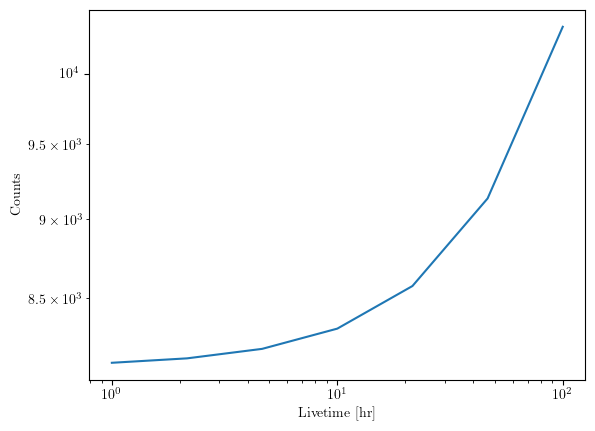

In [6]:
counts = []
for d in datasets_asimov:
    counts.append(d.counts.data.sum())
plt.plot(livetimes, counts)
plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")


## Asimov Cases

In [7]:
true_energy = datasets_asimov[0].exposure.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.015
tilt_pos = 0.015
tilt_cor = 0


bias, resolution = 0,0
print(tilt_neg)

-0.015


In [23]:
datasets_N = []
datasets_N_H0 = []

for d in datasets_asimov:
    sys_d_cor = sys_dataset(dataset_asimov= d,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        bias = bias,
                        resolution = resolution,
                        rnd = False,
                        e_reco_creation=10)
    dataset_cor_N = sys_d_cor.create_dataset_N(10)
    datasets_N.append(dataset_cor_N)
    dataset_cor_N = sys_d_cor.create_dataset_N(10)
    datasets_N_H0.append(dataset_cor_N)
        

In [24]:
zero = 1e-24
if tilt_pos == 0:
    tilt_assumed = zero
else:
    tilt_assumed = tilt_pos

## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/shift_pos**2, 1/tilt_assumed**2])
for d in datasets_N:
    if tilt_assumed >zero:
        d.irf_model.eff_area_model.parameters['tilt_nuisance'].frozen = False
    d.penalising_invcovmatrix = penalising_invcovmatrix
    d.irf_model.e_reco_model.parameters.freeze_all()
for d in datasets_N_H0:
    if tilt_assumed >zero:
        d.irf_model.eff_area_model.parameters['tilt_nuisance'].frozen = False
    d.penalising_invcovmatrix = penalising_invcovmatrix
    d.irf_model.e_reco_model.parameters.freeze_all()


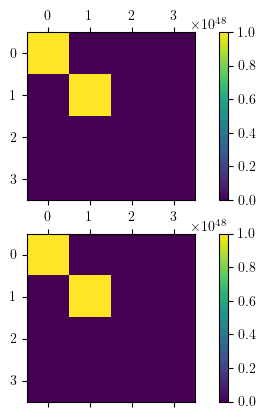

In [10]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

[]

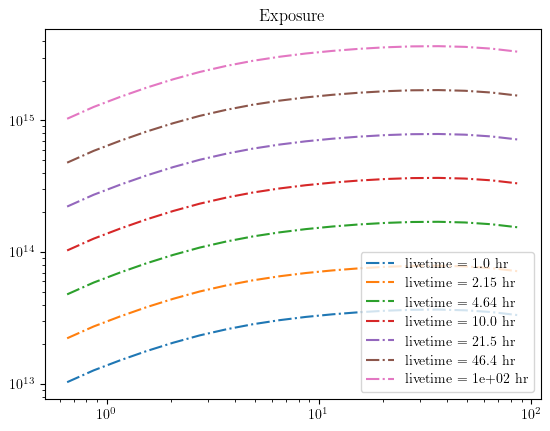

In [11]:
emask = dataset_cor_N.mask.data.sum(axis=2).sum(axis=1) >0 

e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value[emask]

true_energy = dataset_cor_N.exposure.geom.axes[0].center.value[emask]
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]

for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.exposure.data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Exposure")
plt.legend()
plt.loglog()

[]

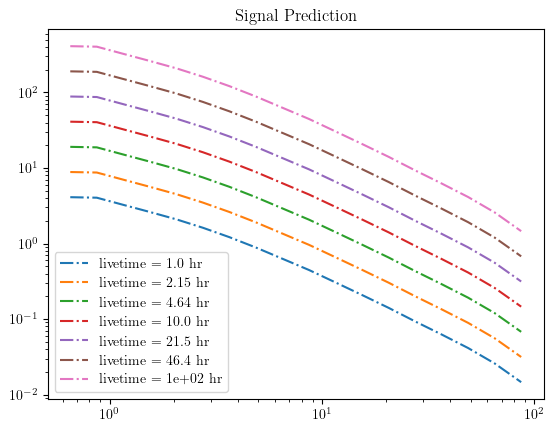

In [12]:

for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_signal().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Signal Prediction")
plt.legend()
plt.loglog()



[]

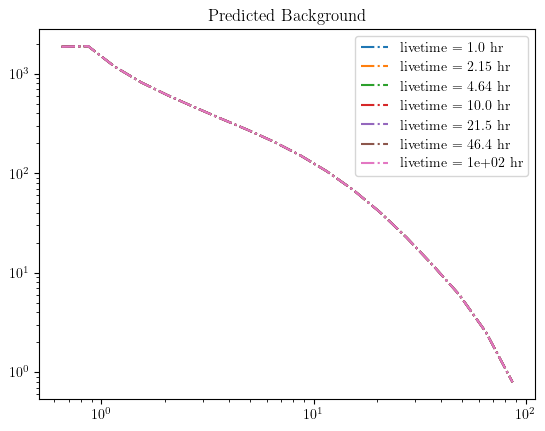

In [13]:
for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_background().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Predicted Background")

plt.legend()
plt.loglog()

In [14]:
%%time
fitting = 0

if fitting:
    for i, d in enumerate(datasets_N):
        print(i)
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)
    
        print("saving")
        path = f'data/8_model_nui_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets_N):
        path = f'data/8_model_nui_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        datasets_N[i] = Dataset_load.load_dataset_N(d, path)        
         
    



read
CPU times: user 659 ms, sys: 232 ms, total: 891 ms
Wall time: 893 ms


In [15]:
print(datasets_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : m9xpWLGd
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.37             
    amplitude                     :   2.06e-12   +/- 9.0e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.02 deg         
    lat_0                         :    -30.222   +/-    0.02 deg         

Component 1: IRFModels

  Name                      : L54Hsjnd-irf
  Datasets names            : L54Hsjnd
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffAreaIRFModel
  Parameters:
    bias                  (frozen):      0.000                   
    resolution            (frozen):      0.000                   
    norm_nuisance                 :

In [16]:
print("read")
datasets = []
for i, d in enumerate(datasets_N):
    path = f'data/8_model_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
    da = Dataset_load.load_dataset(d, path)     
    datasets.append(da)

read


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, 'Best Fit Amplitude [1 / (cm2 s TeV)]')

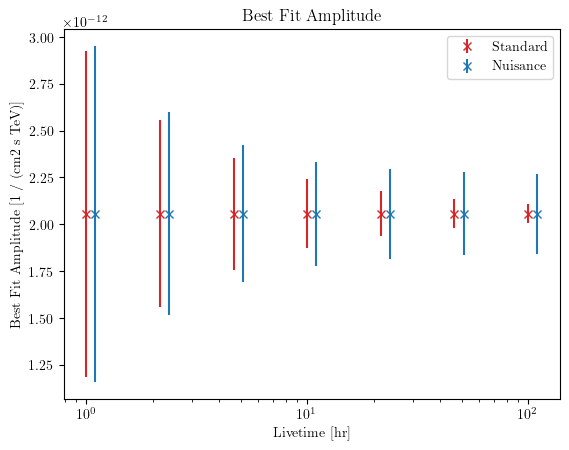

In [17]:
parname = 'amplitude'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar( 1.1* livetimes[i] , val, yerr = err,  fmt='x', color = 'tab:blue')

plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')

plt.title("Best Fit Amplitude")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Amplitude [{par.unit}]")


Text(0, 0.5, 'Best Fit Index []')

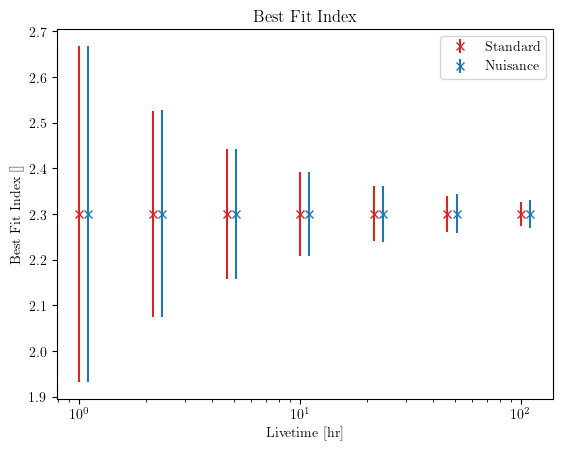

In [18]:
parname = 'index'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar( 1.1* livetimes[i] , val, yerr = err,  fmt='x', color = 'tab:blue')
    
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')
    

plt.title("Best Fit Index")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Index [{par.unit}]")


## Significance

In [26]:
%%time
fitting = 1
if fitting:
    for i, d in enumerate(datasets_N_H0):
        print(i)
        d.models.parameters['amplitude'].value = 0.
        d.models.parameters['amplitude'].frozen = True
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)
        print("saving")
        path = f'data/8_model_nui_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    for i, d in enumerate(datasets_N_H0):
        path = f'data/8_model_nui_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        datasets_N_H0[i]= Dataset_load.load_dataset_N(d, path)
    



0


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

saving
1


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

saving
2


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

saving
3


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

saving
4


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

saving
5


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

saving
6


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

saving
CPU times: user 21min 52s, sys: 32min 7s, total: 53min 59s
Wall time: 14min 36s


In [27]:
datasets_H0 = []
print("read")
for i, d in enumerate(datasets_N):
    path = f'data/8_model_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
    datasets_H0.append(Dataset_load.load_dataset(d, path))

read


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, 'Signifiance [$\\sigma$]')

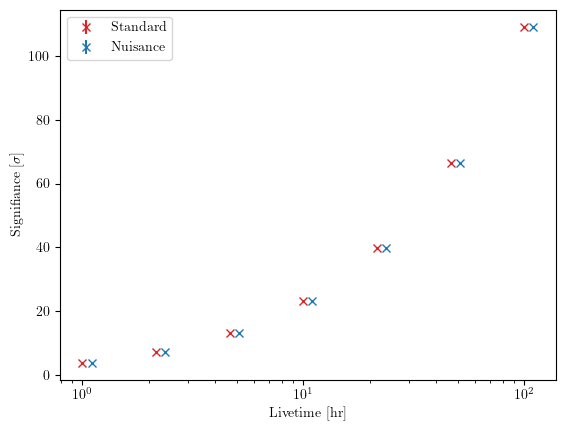

In [28]:
for i, l in enumerate(livetimes):
    H0 = datasets_H0[i].stat_sum()
    H1 = datasets[i].stat_sum()
    plt.plot(l, np.sqrt(np.abs(H0- H1)), marker = 'x', color = 'tab:red')
    
    H0 = datasets_N_H0[i].stat_sum()
    H1 = datasets_N[i].stat_sum()
    plt.plot(l*1.1, np.sqrt(np.abs(H0- H1)), marker = 'x', color = 'tab:blue')
    
    
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')
plt.xscale("log")
plt.legend()
plt.xlabel("Livetime [hr]")
plt.ylabel("Signifiance [$\sigma$]")